In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import rfft
import numpy.random as rand
import ArtificialData
import importlib
importlib.reload(ArtificialData)


<module 'ArtificialData' from '/Users/cassiopeia/Desktop/ASTR5470/Fourier-Transform-Light-Periodicy/ArtificialData.py'>

Artificial Data formation and Alteration/ Pulse Profile 

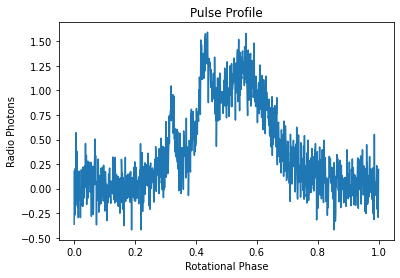

In [80]:
# Phi establishes the rotational phase 
phi = np.linspace(0, 1, 1024)
# .generate_dummy (number of artificial pulses, number of phase bins, root mean square )
pulses, locs = ArtificialData.generate_dummy(1,1024, 500) #RMS used for testing 1. 500 2. 5000 3. 5000 4. 50000
# saves values that are used in pulse profile
np.savez('TestData.npz', *[pulses, locs], **{'pulses' : pulses, 'locs': locs})

# Plotting the Data for a general view 
pulses, locs, gammas, amps = ArtificialData.generate(1, 1024)
plt.plot(phi, pulses[0]) 
plt.xlabel('Rotational Phase')
plt.ylabel('Radio Photons')
plt.title('Pulse Profile')
plt.savefig('Pulse_Profile No.1 Noise.png', bbox_inches='tight')
 

In [81]:
from scipy.signal import unit_impulse as delta
# delta function returns array where all the entries are 0 except for 1 

In [82]:
# repeats unit impulse/delta function
# spacing is n_bin in periodicity 
def shah(period, n = 40): # shah is a train of delta functions was at 50
    shah_list = []
    for i in range(n):
        shah_list.extend(delta(period))
    return np.array(shah_list)
# We create the pulse train of repeating pulse profile that we generated earlier
# the shah function is being used for the amount of times we are repeating 
pulse_train = np.convolve(pulses[0], shah(10000), mode = 'same' )
x_untits = np.array(range(len(pulse_train)))/1e6 # converting from microsec to seconds

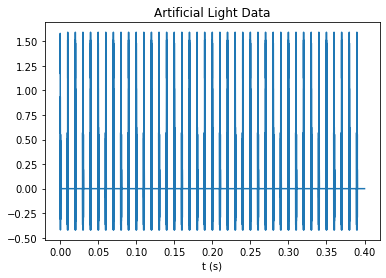

In [83]:
# Here one call from directory and insert their own file

#Below use the the appropriate header withing the file to create x and y 
plt.plot(x_untits, pulse_train)
plt.xlabel('t (s)')
plt.title('Artificial Light Data')
plt.savefig('Artificial_light No.1 Noise.png', bbox_inches='tight')


Main Code: Converting Pulse Data into Harmonics Using FFT 

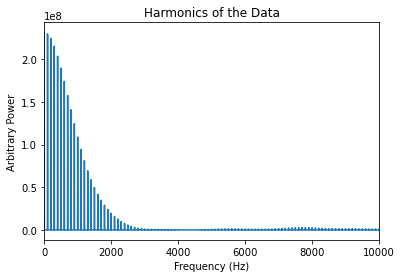

In [84]:
# This is the 
trainFFT = abs(np.fft.rfft(pulse_train))**2
x_untits = 1e6*np.array(range(len(trainFFT)))/len(pulse_train) #converting microseconds to seconds / x units 
plt.plot(x_untits, trainFFT)
# Alter the Xlim to allow for any changes within the harmonics 
plt.xlim(0, 10000)
# x axis needs frq (Hz) which is 1/total number of bins
plt.xlabel('Frequency (Hz)')
plt.ylabel('Arbitrary Power')
plt.title("Harmonics of the Data")
plt.savefig('Harmonic of the Data No. 1 Noise.png', bbox_inches='tight')